In [1]:
!git clone https://github.com/emanhamed/Houses-dataset

Cloning into 'Houses-dataset'...
remote: Enumerating objects: 2166, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 2166 (delta 0), reused 0 (delta 0), pack-reused 2165
Receiving objects: 100% (2166/2166), 176.26 MiB | 13.96 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [2]:
!ls

Houses-dataset	HousesInfo.txt	sample_data


In [3]:
import os
import glob
import random
from tqdm import tqdm

import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [4]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import concatenate

import argparse
import locale

# Tabular Data Cleaning

In [5]:
data_path = "HousesInfo.txt"
columns = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
data = pd.read_csv(data_path, sep=" ", names=columns)
data.head()

,bedrooms,bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


In [6]:
mask_zip_frequency = data.zipcode.value_counts() >= 10
list_frequent_zip_codes = data.zipcode.value_counts()[mask_zip_frequency].index.tolist()
list_frequent_zip_codes

[92276,
 93510,
 93446,
 92880,
 94501,
 91901,
 92677,
 94531,
 85255,
 96019,
 85266,
 81524,
 92021,
 93111,
 95220]

In [7]:
len(list_frequent_zip_codes)

15

In [8]:
print(data.shape)

(535, 5)


In [9]:
mask_filtered_zip_codes =  data.zipcode.isin(list_frequent_zip_codes)
data = data[mask_filtered_zip_codes]
print(data.shape)
data.head()

(462, 5)


,bedrooms,bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
2,3,4.0,3923,85266,889000
4,3,4.0,4116,85266,971226
5,4,5.0,4581,85266,1249000
7,4,5.0,5524,85266,1698000


In [10]:
mask_area = data.area < 5000
data = data[mask_area]
print(data.shape)

(454, 5)


In [11]:
mask_bedrooms = data.bedrooms < 6
data = data[mask_bedrooms]
print(data.shape)

(439, 5)


In [12]:
data.head()

,bedrooms,bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
2,3,4.0,3923,85266,889000
4,3,4.0,4116,85266,971226
5,4,5.0,4581,85266,1249000
8,3,4.0,4229,85255,1749000


# Image Data Cleaning

Houses-dataset/Houses Dataset/425_bathroom.jpg


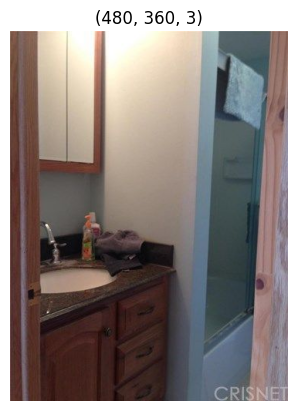

In [13]:
IMAGE_DIR = "Houses-dataset/Houses Dataset"
IMAGE_FILE_LIST = os.listdir(IMAGE_DIR)

length_image_file_list = len(IMAGE_FILE_LIST)
random_index = random.randint(0, length_image_file_list)

sample_image_dir = os.path.join(IMAGE_DIR, IMAGE_FILE_LIST[random_index])
print(sample_image_dir)

sample_image = mpimg.imread(sample_image_dir)
plt.imshow(sample_image)
plt.title(f"{sample_image.shape}")
plt.axis(False);

In [14]:
def load_image_and_resize(input_image_path, dimensions = (224, 224)):
      image = mpimg.imread(input_image_path)
      resized_image = cv2.resize(
          image,
          dimensions,
          interpolation = cv2.INTER_AREA
      )
      return resized_image

In [15]:
data_images = []

width = height = 224

dim = (width, height)


for index in tqdm(range(1, 536)):

  row_images = []

  for img_path in IMAGE_FILE_LIST:
    if img_path.startswith(f"{index}_"):
      row_images.append(img_path)

  if len(row_images) != 4:
    print(f"Skipping row {index}")
    continue



  for path in row_images:

    if path.endswith("bathroom.jpg"):
      full_path = os.path.join(IMAGE_DIR, path)
      bathroom_img = load_image_and_resize(full_path)


    elif path.endswith("bedroom.jpg"):
      full_path = os.path.join(IMAGE_DIR, path)
      bedroom_img = load_image_and_resize(full_path)


    elif path.endswith("frontal.jpg"):
      full_path = os.path.join(IMAGE_DIR, path)
      frontal_img = load_image_and_resize(full_path)


    elif path.endswith("kitchen.jpg"):
      full_path = os.path.join(IMAGE_DIR, path)
      kitchen_img = load_image_and_resize(full_path)


    else:
      raise ValueError("Invalid Name Convention")

  row_tuple = (frontal_img, bedroom_img, kitchen_img, bathroom_img)
  data_images.append(row_tuple)

100%|██████████| 535/535 [00:16<00:00, 32.70it/s]


In [16]:
print(len(data_images))

535


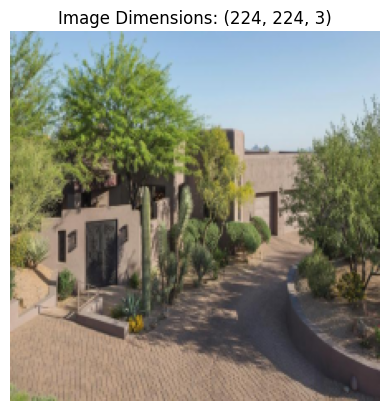

In [17]:
random_index = random.randint(0, len(data_images))
random_image = data_images[random_index][0]
plt.imshow(random_image)
plt.title(f"Image Dimensions: {random_image.shape}")
plt.axis(False);

In [18]:
data.index

Int64Index([  0,   2,   4,   5,   8,  10,  11,  13,  14,  15,
            ...
            523, 525, 526, 527, 528, 529, 530, 532, 533, 534],
           dtype='int64', length=439)

In [19]:
front_images_list = [row[0] for row in data_images]
front_images_array = np.array(front_images_list)

In [20]:
front_images_array.shape

(535, 224, 224, 3)

In [21]:
front_images_array = front_images_array[data.index.tolist()]
print(front_images_array.shape)

(439, 224, 224, 3)


In [22]:
data.shape

(439, 5)

# Feature Engineering

In [23]:
front_images_array = front_images_array / 255.0

In [24]:
data.columns

Index(['bedrooms', 'bathrooms', 'area', 'zipcode', 'price'], dtype='object')

In [25]:
train_data, test_data, train_images, test_images = train_test_split(
    data,
    front_images_array,
    test_size = 0.2,
    stratify=data.zipcode,
    random_state = 7
)

In [26]:
train_labels = train_data.pop("price")
test_labels = test_data.pop("price")

train_features = train_data
test_features = test_data

print(f"Train data dimensions: {train_features.shape} {train_labels.shape} {train_images.shape}")
print(f"Train data dimensions: {test_features.shape} {test_labels.shape} {test_images.shape}")

Train data dimensions: (351, 4) (351,) (351, 224, 224, 3)
Train data dimensions: (88, 4) (88,) (88, 224, 224, 3)


In [27]:
tabular_columns = ['bedrooms', 'bathrooms', 'area']

max_tabular_values = train_features.loc[:, tabular_columns].max()
max_tabular_values

bedrooms        5.0
bathrooms       5.0
area         4886.0
dtype: float64

In [28]:
train_tabular_features = train_features.loc[:, tabular_columns]
train_tabular_features = train_tabular_features.div(max_tabular_values)

test_tabular_features = test_features.loc[:, tabular_columns]
test_tabular_features = test_tabular_features.div(max_tabular_values)


train_tabular_features.head()

,bedrooms,bathrooms,area
450,0.6,0.6,0.574703
203,0.6,0.7,0.557511
471,0.4,0.4,0.255424
238,1.0,0.6,0.654932
220,0.8,0.4,0.471551


In [29]:
train_zip_codes = pd.get_dummies(train_features.zipcode)
test_zip_codes = pd.get_dummies(test_features.zipcode)

print(train_tabular_features.shape, train_zip_codes.shape)
print(test_tabular_features.shape, test_zip_codes.shape)

(351, 3) (351, 15)
(88, 3) (88, 15)


In [30]:

processed_train_features = pd.concat(
    [
        train_tabular_features,
        train_zip_codes
    ],
    axis=1,
).reset_index(drop=True)

print(processed_train_features.shape)
processed_train_features.head()

(351, 18)


,bedrooms,bathrooms,area,81524,85255,85266,91901,92021,92276,92677,92880,93111,93446,93510,94501,94531,95220,96019
0,0.6,0.6,0.574703,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0.6,0.7,0.557511,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0.4,0.4,0.255424,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1.0,0.6,0.654932,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0.8,0.4,0.471551,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [31]:
processed_test_features = pd.concat(
    [
        test_tabular_features,
        test_zip_codes
    ],
    axis=1
).reset_index(drop=True)

print(processed_test_features.shape)
processed_test_features.head()

(88, 18)


,bedrooms,bathrooms,area,81524,85255,85266,91901,92021,92276,92677,92880,93111,93446,93510,94501,94531,95220,96019
0,1.0,1.0,0.988334,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,0.6,0.648178,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0.6,0.6,0.489153,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0.8,0.5,0.367172,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.6,0.3,0.323578,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [32]:
train_preprocessed_labels = train_labels / train_labels.max()
test_preprocessed_labels = test_labels / train_labels.max()

In [33]:
print(f"Train data dimensions: {processed_train_features.shape} {train_labels.shape} {train_preprocessed_labels.shape}")
print(f"Train data dimensions: {processed_test_features.shape} {test_labels.shape} {test_preprocessed_labels.shape}")

Train data dimensions: (351, 18) (351,) (351,)
Train data dimensions: (88, 18) (88,) (88,)


# Model Creation

In [34]:
def create_mlp(dim):
	# define our MLP network
	model = Sequential()
	model.add(Dense(8, input_dim=dim, activation="relu"))
	model.add(Dense(4, activation="relu"))

	return model

def create_cnn(width, height, depth, filters=(16, 32, 64)):
	# initialize the input shape and channel dimension, assuming
	# TensorFlow/channels-last ordering
	inputShape = (height, width, depth)
	chanDim = -1

	# define the model input
	inputs = Input(shape=inputShape)

	# loop over the number of filters
	for (i, f) in enumerate(filters):
		# if this is the first CONV layer then set the input
		# appropriately
		if i == 0:
			x = inputs

		# CONV => RELU => BN => POOL
		x = Conv2D(f, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)

	# flatten the volume, then FC => RELU => BN => DROPOUT
	x = Flatten()(x)
	x = Dense(16)(x)
	x = Activation("relu")(x)
	x = BatchNormalization(axis=chanDim)(x)
	x = Dropout(0.5)(x)

	# apply another FC layer, this one to match the number of nodes
	# coming out of the MLP
	x = Dense(4)(x)
	x = Activation("relu")(x)

	# construct the CNN
	model = Model(inputs, x)

	# return the CNN
	return model

In [35]:
channels = 3

mlp = create_mlp(processed_train_features.shape[1])
cnn = create_cnn(width, height, channels)

In [36]:
combinedInput = concatenate([mlp.output, cnn.output])

x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

model = Model(inputs=[mlp.input, cnn.input], outputs=x)

In [37]:
opt = Adam(learning_rate=1e-3)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

In [38]:
print("[INFO] training model...")
history = model.fit(
	x = [
    processed_train_features,
    train_images
  ],
  y=train_preprocessed_labels,
	validation_data=(

      [
         processed_test_features,
         test_images
      ],
      test_preprocessed_labels
  ),
	epochs=200,
  batch_size=8
 )

[INFO] training model...
Epoch 1/200
44/44 [==============================] - 11s 32ms/step - loss: 462.6550 - val_loss: 2163.8877
Epoch 2/200
44/44 [==============================] - 1s 14ms/step - loss: 275.7296 - val_loss: 91.8360
Epoch 3/200
44/44 [==============================] - 1s 14ms/step - loss: 115.4561 - val_loss: 88.1982
Epoch 4/200
44/44 [==============================] - 1s 14ms/step - loss: 88.0414 - val_loss: 123.9406
Epoch 5/200
44/44 [==============================] - 1s 14ms/step - loss: 80.3044 - val_loss: 365.4204
Epoch 6/200
44/44 [==============================] - 1s 14ms/step - loss: 73.8684 - val_loss: 1931.5085
Epoch 7/200
44/44 [==============================] - 1s 14ms/step - loss: 71.9799 - val_loss: 4019.7229
Epoch 8/200
44/44 [==============================] - 1s 16ms/step - loss: 73.1095 - val_loss: 4010.5400
Epoch 9/200
44/44 [==============================] - 1s 19ms/step - loss: 71.0314 - val_loss: 4032.4255
Epoch 10/200
44/44 [=====================

In [41]:


# make predictions on the testing data
print("[INFO] predicting house prices...")
test_preds = model.predict(
    [
      processed_test_features,
      test_images
    ]
)

[INFO] predicting house prices...
3/3 [==============================] - 0s 15ms/step


In [42]:
# make predictions on the testing data
print("[INFO] predicting house prices...")
train_preds = model.predict(
    [
      processed_train_features,
      train_images
    ]
)

[INFO] predicting house prices...
11/11 [==============================] - 1s 55ms/step


In [43]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error


train_score = mean_squared_error(train_preds, train_preprocessed_labels.values, squared=True)
test_score = mean_squared_error(test_preds, test_preprocessed_labels.values, squared=True)

print(f"Train RMSE: {train_score:.4f} - Test RMSE: {test_score:.4f}")

Train RMSE: 0.0033 - Test RMSE: 0.0012


In [44]:
from sklearn.metrics import mean_absolute_percentage_error


train_mape_score = mean_absolute_percentage_error(train_preds, train_labels.values)
test_mape_score = mean_absolute_percentage_error(test_preds, test_labels.values)
print(f"Train MAPE: {train_mape_score:.4f} - Test RMSE: {test_mape_score:.4f}")

Train MAPE: 6549512.0488 - Test RMSE: 6557497.1215
